In [53]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

<h1> Load the Data </h1>

In [54]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [55]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [56]:
data = read_text("/kaggle/input/fra-engl/fra.txt")
fr_eng = to_lines(data)
fr_eng = array(fr_eng)

In [57]:
fr_eng.shape

(232736, 3)

<h1> Text Cleaning / Preprocessing</h1>

In [58]:
# Remove punctuation
fr_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fr_eng[:,0]]
fr_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in fr_eng[:,1]]

fr_eng

array([['Go', 'Va ',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)'],
       ['Go', 'Marche',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)'],
       ['Go', 'En route ',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8267435 (felix63)'],
       ...,
       ['If someone who doesnt know your background says that you sound like a native speaker it means they probably noticed something about your speaking that made them realize you werent a native speaker In other words you dont really sound like a native speaker',
        'Si quelquun qui ne connaît pas vos antécédents dit que vous parlez comme un locuteur natif cela veut dire quil a probablement remarqué quelque chose à propos de votre élocution qui lui a fait prendre conscience que vous nêtes pas un locuteur natif En dautres termes vous ne parlez pas vraiment comme un locuteur natif',
        'CC-BY 2.0 (France) Attribution: ta

In [59]:
# convert text to lowercase
for i in range(len(fr_eng)):
    fr_eng[i,0] = fr_eng[i,0].lower()
    fr_eng[i,1] = fr_eng[i,1].lower()

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


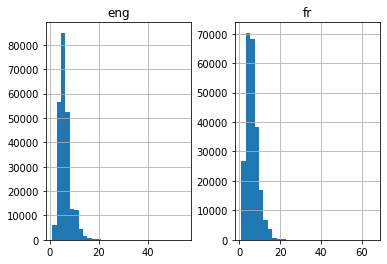

In [60]:
# empty lists
eng_l = []
fr_l = []

# populate the lists with sentence lengths
for i in fr_eng[:,0]:
      eng_l.append(len(i.split()))

for i in fr_eng[:,1]:
      fr_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'fr':fr_l})

length_df.hist(bins = 30)
plt.show()

In [12]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [15]:
# prepare english tokenizer
eng_tokenizer = tokenization(fr_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 5964


In [17]:
fr_tokenizer = tokenization(fr_eng[:, 1])
fr_vocab_size = len(fr_tokenizer.word_index) + 1

fr_length = 8
print('french Vocabulary Size: %d' % fr_vocab_size)

french Vocabulary Size: 13742


In [18]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [19]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(fr_eng, test_size=0.2, random_state = 12)

In [20]:
# prepare training data
trainX = encode_sequences(fr_tokenizer, fr_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(fr_tokenizer, fr_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

<h1> Define the Model</h1>

In [21]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [25]:
# model compilation
#model = define_model(fr_vocab_size, eng_vocab_size, fr_length, eng_length, 512)
# Model compilation
model = define_model(fr_vocab_size, eng_vocab_size, fr_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


<h1> Fit the Model</h1>

Epoch 1/30
63/63 [==============================] - 12s 121ms/step - loss: 4.3101 - accuracy: 0.5303 - val_loss: 2.7157 - val_accuracy: 0.5909

Epoch 00001: val_loss improved from inf to 2.71568, saving model to model.h1.24_jan_19
Epoch 2/30
63/63 [==============================] - 6s 101ms/step - loss: 2.6788 - accuracy: 0.5927 - val_loss: 2.6277 - val_accuracy: 0.5970

Epoch 00002: val_loss improved from 2.71568 to 2.62769, saving model to model.h1.24_jan_19
Epoch 3/30
63/63 [==============================] - 6s 98ms/step - loss: 2.5339 - accuracy: 0.6061 - val_loss: 2.4645 - val_accuracy: 0.6193

Epoch 00003: val_loss improved from 2.62769 to 2.46449, saving model to model.h1.24_jan_19
Epoch 4/30
63/63 [==============================] - 6s 97ms/step - loss: 2.3281 - accuracy: 0.6265 - val_loss: 2.2837 - val_accuracy: 0.6404

Epoch 00004: val_loss improved from 2.46449 to 2.28373, saving model to model.h1.24_jan_19
Epoch 5/30
63/63 [==============================] - 6s 100ms/step - l

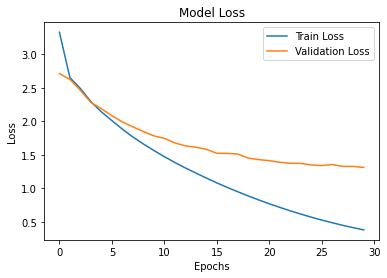

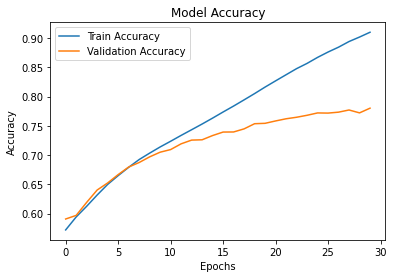

In [26]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Train the model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split=0.2, callbacks=[checkpoint], 
                    verbose=1)

# Plot loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.show()


In [27]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(testX, testY.reshape(testY.shape[0], testY.shape[1], 1), verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

313/313 [==============================] - 2s 6ms/step - loss: 1.3004 - accuracy: 0.7813
Test Loss: 1.3003896474838257
Test Accuracy: 0.7813125252723694


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

<h1> Prediction on unseen data</h1>

In [28]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [29]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [30]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [31]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [32]:
# print 15 rows randomly
pred_df.head(15)

,actual,predicted
0,ill stop gambling,ill go chess
1,i saw tom,i saw tom
2,how big is he,he is tall
3,youre silly,youre being silly
4,thats why im here,thats why im here
5,i dont have enough,i wasnt enough
6,whats on your desk,whats on your desk
7,im extremely sorry,im extremely sorry
8,theyre special,theyre are
9,its a school night,it outside


In [33]:
def translate_sentence(model, input_sentence, fr_tokenizer, eng_tokenizer, fr_length):

    input_sequence = encode_sequences(fr_tokenizer, fr_length, [input_sentence])
    
    # Étape 2 : Prédire avec le modèle
    predicted_sequence = model.predict(input_sequence)
    
    # Étape 3 : Décodage des prédictions
    predicted_words = []
    for index in predicted_sequence[0].argmax(axis=1):  # Prendre les indices avec la probabilité la plus élevée
        word = get_word(index, eng_tokenizer)
        if word is not None:
            predicted_words.append(word)
    
    # Étape 4 : Combiner les mots pour former la phrase traduite
    predicted_sentence = ' '.join(predicted_words)
    return predicted_sentence


In [34]:
# Exemple de phrase à traduire
input_sentence = 'Arrête-toi'

# Traduire avec la fonction
translated_sentence = translate_sentence(model, input_sentence, fr_tokenizer, eng_tokenizer, fr_length)

# Afficher la traduction
print("Phrase en français :", input_sentence)
print("Phrase traduite en anglais :", translated_sentence)


Phrase en français : Arrête-toi
Phrase traduite en anglais : stop you


In [52]:
# Exemple de phrase à traduire
input_sentence = 'je pense'

# Traduire avec la fonction
translated_sentence = translate_sentence(model, input_sentence, fr_tokenizer, eng_tokenizer, fr_length)

# Afficher la traduction
print("Phrase en français :", input_sentence)
print("Phrase traduite en anglais :", translated_sentence)


Phrase en français : je pense
Phrase traduite en anglais : i think so


In [38]:
# Exemple de phrase à traduire
input_sentence = 'je suis triste'

# Traduire avec la fonction
translated_sentence = translate_sentence(model, input_sentence, fr_tokenizer, eng_tokenizer, fr_length)

# Afficher la traduction
print("Phrase en français :", input_sentence)
print("Phrase traduite en anglais :", translated_sentence)


Phrase en français : je suis triste
Phrase traduite en anglais : im sad
